In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [72]:
df = pd.read_csv("VOO.csv")

In [73]:
chg = list(df.Close.pct_change()[1:])
dd = 0
ud = 0
uu = 0
du = 0
i = 0
dState = []
uState = []
while i < len(chg)-1:
    if chg[i]< 0 and chg[i+1]<0:
        dd+=1
        dState.append(chg[i+1])
    if chg[i]< 0 and chg[i+1]>0:
        du+=1
        uState.append(chg[i+1])
    if chg[i]> 0 and chg[i+1]<0:
        ud+=1
        dState.append(chg[i+1])
    if chg[i]> 0 and chg[i+1]>0:
        uu+=1
        uState.append(chg[i+1])
    i+=1
chgprobs = [uu/(uu+ud),ud/(uu+ud),du/(du+dd),dd/(du+dd)]

In [74]:
chgprobs

[0.5205479452054794,
 0.4794520547945205,
 0.6634615384615384,
 0.33653846153846156]

(array([79., 45.,  9.,  4.,  3.,  0.,  2.,  1.,  0.,  2.]),
 array([8.61718311e-05, 9.61395041e-03, 1.91417290e-02, 2.86695076e-02,
        3.81972861e-02, 4.77250647e-02, 5.72528433e-02, 6.67806219e-02,
        7.63084004e-02, 8.58361790e-02, 9.53639576e-02]),
 <a list of 10 Patch objects>)

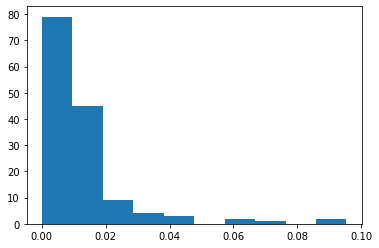

In [75]:
plt.hist(uState)

In [76]:
PosdState = [-x for x in dState]

In [77]:
mu_d = sum([np.log(x) for x in PosdState]) / len(PosdState)
sigma_d = np.sqrt(sum([(np.log(x) - mu_d)**2 for x in PosdState]) / len(PosdState))
mu_u = sum([np.log(x) for x in uState]) / len(uState)
sigma_u = np.sqrt(sum([(np.log(x) - mu_u)**2 for x in uState]) / len(uState))
down_dist = (np.exp(mu_d),sigma_d)
up_dist = (np.exp(mu_u),sigma_u)

In [78]:
def MarkovChain(prob_matrix,num_steps, currprice):
    chain = []
    prices = [currprice]
    start = st.uniform.rvs(0,1)
    if start > .5:
        CurrState = "u"
        currprice += st.lognorm.rvs(scale = up_dist[0],s = up_dist[1])*currprice
    else:
        CurrState = "d"
        currprice -= st.lognorm.rvs(scale = down_dist[0],s = down_dist[1])*currprice
    S = 0
    while S != num_steps:
        chain.append(CurrState)
        prices.append(max(currprice,0))
        if CurrState == "u":
            trans = st.uniform.rvs(0,1)
            if trans < prob_matrix[0]:
                CurrState = "u"
                currprice += st.lognorm.rvs(scale = up_dist[0],s = up_dist[1])*currprice
            else:
                CurrState = "d"
                currprice -= st.lognorm.rvs(scale = down_dist[0],s = down_dist[1])*currprice
        if CurrState == "d":
            trans = st.uniform.rvs(0,1)
            if trans < prob_matrix[2]:
                CurrState = "u"
                currprice += st.lognorm.rvs(scale = up_dist[0],s = up_dist[1])*currprice
            else:
                CurrState = "d"
                currprice -= st.lognorm.rvs(scale = down_dist[0],s = down_dist[1])*currprice
        S+=1
    return chain, prices

In [79]:
MarkovChain(chgprobs,25,df.Close[252])

(['u',
  'u',
  'u',
  'u',
  'd',
  'u',
  'u',
  'u',
  'd',
  'd',
  'u',
  'u',
  'u',
  'u',
  'u',
  'd',
  'd',
  'u',
  'u',
  'u',
  'u',
  'u',
  'u',
  'u',
  'u'],
 [360.160004,
  360.36046668738743,
  366.670765836102,
  369.59159050816083,
  370.748655069075,
  313.7743116127534,
  324.74195742613813,
  324.6333087396811,
  335.63977444984084,
  303.43925097960494,
  294.1048446644273,
  295.3969264010395,
  298.07184102407314,
  309.0812606045348,
  326.19469751888346,
  326.91518428357335,
  320.6147076261602,
  319.7493480395437,
  322.3154985107769,
  323.7373842349781,
  324.1202041592482,
  323.30354446001047,
  323.63171810517844,
  324.5396838766164,
  328.2704194861761,
  331.8009946175848])

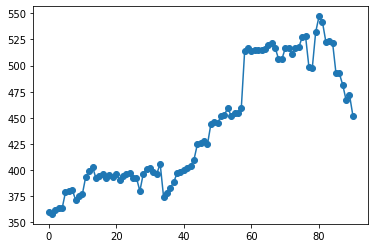

In [80]:
n = 90
d = MarkovChain(chgprobs,n,df.Close[252])[1]
plt.scatter([t for t in range(n+1)],d)
plt.plot([t for t in range(n+1)],d)
plt.show()

In [81]:
priceDist = []
for t in range(100000):
    priceDist.append(MarkovChain(chgprobs,1,df.Close[252])[1][-1])

Text(0, 0.5, 'Number of Observations')

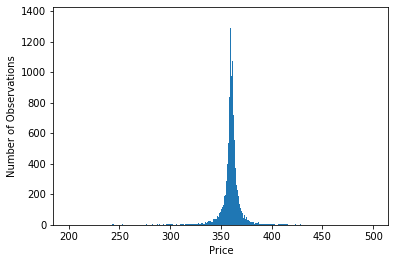

In [82]:
binwidth = .1
plt.hist(priceDist, bins=np.arange(200, 500, binwidth))
plt.xlabel('Price')
plt.ylabel('Number of Observations')

In [83]:
price = pd.Series(priceDist)
price.describe()

count    100000.000000
mean        359.637542
std          12.388151
min           0.000000
25%         357.542357
50%         360.293210
75%         362.830503
max         854.083319
dtype: float64

In [84]:
(round(price.mean()-1.282*price.std(),2),round(price.mean()+1.282*price.std(),2))

(343.76, 375.52)